<a href="https://colab.research.google.com/github/andsoler11/cryptoPrediction/blob/master/crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import requests


In [ ]:
market = 'SOLUSDT'
tick_interval = '1h'

In [ ]:
forest_depth = 500
model = RandomForestRegressor(forest_depth)

In [ ]:
# altcoins adjustment
alt_adjust = 1000000  # cardanobtc
#alt_adjust = 10000  # vetbtc
# alt_adjust = 1

In [ ]:
url_prices = 'https://api.binance.com/api/v1/klines?symbol='+market+'&interval='+tick_interval+'&limit='+str(1000)
init_candles = requests.get(url_prices).json()

In [ ]:
prediction_candles = 50
time_window = 7
shift_val = 1

In [ ]:
df = pd.DataFrame(columns=['open_time','open', 'high', 'low','close','volume','close_time','quote','trades','takers_buy_base','takers_buy_quote','ignore'])
for i in range(len(init_candles)):
    df.loc[i] = init_candles[i]
df=df.drop(['ignore'],axis=1)
df = df.astype(float)

In [ ]:
df[['open_time','open', 'high', 'low','close']] = df[['open_time','open', 'high', 'low','close']]*alt_adjust
df.tail(5)

,open_time,open,high,low,close,volume,close_time,quote,trades,takers_buy_base,takers_buy_quote
995,1.635797e+18,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,1.635800e+12,2.739149e+07,35575.0,67546.55,1.378248e+07
996,1.635800e+18,202510000.0,203220000.0,200800000.0,202690000.0,47934.70,1.635804e+12,9.680862e+06,15719.0,23678.76,4.783188e+06
997,1.635804e+18,202680000.0,204920000.0,202630000.0,203310000.0,40556.94,1.635808e+12,8.273311e+06,14580.0,20328.81,4.147871e+06
998,1.635808e+18,203320000.0,204320000.0,203000000.0,203900000.0,33134.04,1.635811e+12,6.748268e+06,9275.0,15341.78,3.124631e+06
999,1.635811e+18,203910000.0,204000000.0,203890000.0,203980000.0,506.86,1.635815e+12,1.033784e+05,272.0,343.24,7.000921e+04


In [ ]:
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df['close_time'] = df['close_time'].dt.tz_localize('utc').dt.tz_convert('America/Bogota')
df = df.set_index('close_time')

In [ ]:
df.tail(3)

,open_time,open,high,low,close,volume,quote,trades,takers_buy_base,takers_buy_quote
close_time,,,,,,,,,,
2021-11-01 17:59:59.999000-05:00,1.635804e+18,202680000.0,204920000.0,202630000.0,203310000.0,40556.94,8.273311e+06,14580.0,20328.81,4.147871e+06
2021-11-01 18:59:59.999000-05:00,1.635808e+18,203320000.0,204320000.0,203000000.0,203900000.0,33134.04,6.748268e+06,9275.0,15341.78,3.124631e+06
2021-11-01 19:59:59.999000-05:00,1.635811e+18,203910000.0,204000000.0,203890000.0,203980000.0,506.86,1.033784e+05,272.0,343.24,7.000921e+04


In [ ]:
next_close_since_data = df[-1:].index
next_close_since_data[0]

Timestamp('2021-11-01 19:59:59.999000-0500', tz='America/Bogota')

In [ ]:
df.iloc[-1:,:]['close'] = np.nan
df.dropna(inplace=True) # last line is not real in binance because it is not closed yet

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['next_close'] = df['close'].shift(-shift_val)  # negative value... this is very important, negative means future value

df = df[['open', 'high', 'low','close','volume', 'next_close']]

#df = df[['open', 'high', 'low','close','volume', 'next_close', 'upperband', 'middleband', 'lowerband']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 2021-09-21 02:59:59.999000-05:00 to 2021-11-01 18:59:59.999000-05:00
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        999 non-null    float64
 1   high        999 non-null    float64
 2   low         999 non-null    float64
 3   close       999 non-null    float64
 4   volume      999 non-null    float64
 5   next_close  998 non-null    float64
dtypes: float64(6)
memory usage: 54.6 KB


In [ ]:
df.tail(5)

,open,high,low,close,volume,next_close
close_time,,,,,,
2021-11-01 14:59:59.999000-05:00,199420000.0,204500000.0,199000000.0,204040000.0,105196.30,202500000.0
2021-11-01 15:59:59.999000-05:00,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,202690000.0
2021-11-01 16:59:59.999000-05:00,202510000.0,203220000.0,200800000.0,202690000.0,47934.70,203310000.0
2021-11-01 17:59:59.999000-05:00,202680000.0,204920000.0,202630000.0,203310000.0,40556.94,203900000.0
2021-11-01 18:59:59.999000-05:00,203320000.0,204320000.0,203000000.0,203900000.0,33134.04,NaN


In [ ]:
def plotting(df, width=0.1):
    
    fig = plt.figure()
    fig.set_size_inches((20, 8))  # figure size
    
    # sub-figures relative positions
    ax_candle = fig.add_axes((0, 0.2, 1, 1))
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # x axis as date
    ax_candle.xaxis_date()
    
    # close prices
    ax_candle.plot(df['close'])
    
    # volume
    ax_vol.bar(df.index, df["volume"] / 1000, width=width)   
    ax_vol.set_ylabel("BTC * 1000")  # just for intuitive view
    
    # title and plot
    ax_candle.set_title(market)
    plt.grid()
    plt.show()
    return

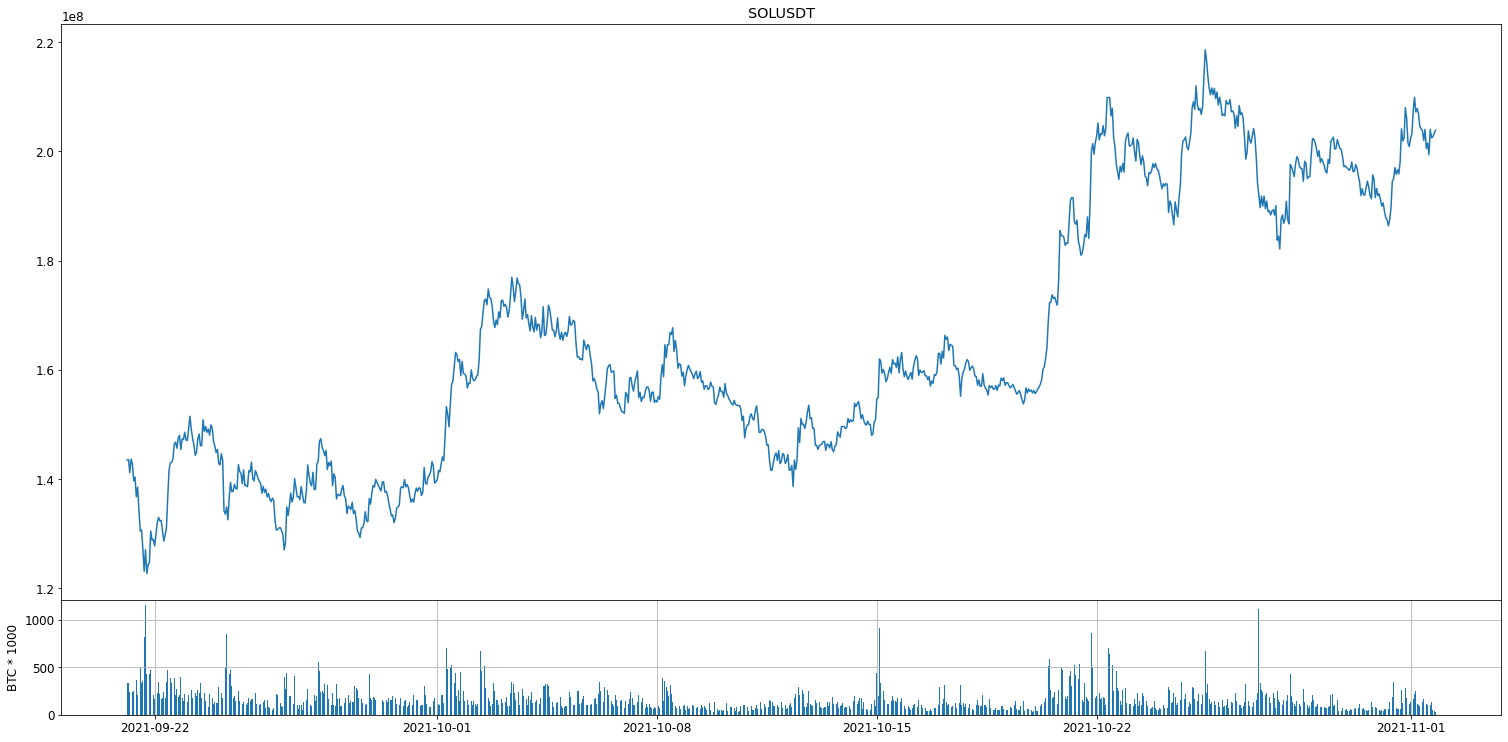

In [ ]:
plotting(df, width=0.025)

In [ ]:

def create_time_window(df, time_window):
    df_cols = df.columns
    for i in range(1,time_window): # for time_window days, this was set before
        for col in df_cols:
            df[f'{col}_'+str(i)] = df[col].shift(i)
    return df

historical_df = create_time_window(df, time_window)

In [ ]:
test_last_closed_line=historical_df.iloc[-1:,:]  # last line for predciting

In [ ]:

test_last_closed_line

,open,high,low,close,volume,next_close,open_1,high_1,low_1,close_1,volume_1,next_close_1,open_2,high_2,low_2,close_2,volume_2,next_close_2,open_3,high_3,low_3,close_3,volume_3,next_close_3,open_4,high_4,low_4,close_4,volume_4,next_close_4,open_5,high_5,low_5,close_5,volume_5,next_close_5,open_6,high_6,low_6,close_6,volume_6,next_close_6
close_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-01 18:59:59.999000-05:00,203320000.0,204320000.0,203000000.0,203900000.0,33134.04,NaN,202680000.0,204920000.0,202630000.0,203310000.0,40556.94,203900000.0,202510000.0,203220000.0,200800000.0,202690000.0,47934.7,203310000.0,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,202690000.0,199420000.0,204500000.0,199000000.0,204040000.0,105196.3,202500000.0,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0


In [ ]:
historical_df.tail(3)

,open,high,low,close,volume,next_close,open_1,high_1,low_1,close_1,volume_1,next_close_1,open_2,high_2,low_2,close_2,volume_2,next_close_2,open_3,high_3,low_3,close_3,volume_3,next_close_3,open_4,high_4,low_4,close_4,volume_4,next_close_4,open_5,high_5,low_5,close_5,volume_5,next_close_5,open_6,high_6,low_6,close_6,volume_6,next_close_6
close_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-01 16:59:59.999000-05:00,202510000.0,203220000.0,200800000.0,202690000.0,47934.70,203310000.0,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,202690000.0,199420000.0,204500000.0,199000000.0,204040000.0,105196.30,202500000.0,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0,204050000.0,204310000.0,200530000.0,200570000.0,110725.21,201540000.0,202040000.0,204210000.0,201800000.0,204050000.0,91219.21,200570000.0
2021-11-01 17:59:59.999000-05:00,202680000.0,204920000.0,202630000.0,203310000.0,40556.94,203900000.0,202510000.0,203220000.0,200800000.0,202690000.0,47934.70,203310000.0,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,202690000.0,199420000.0,204500000.0,199000000.0,204040000.0,105196.30,202500000.0,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0,204050000.0,204310000.0,200530000.0,200570000.0,110725.21,201540000.0
2021-11-01 18:59:59.999000-05:00,203320000.0,204320000.0,203000000.0,203900000.0,33134.04,NaN,202680000.0,204920000.0,202630000.0,203310000.0,40556.94,203900000.0,202510000.0,203220000.0,200800000.0,202690000.0,47934.70,203310000.0,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,202690000.0,199420000.0,204500000.0,199000000.0,204040000.0,105196.30,202500000.0,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0


In [ ]:
historical_df.dropna(inplace=True)

In [ ]:

historical_df.tail(5)

,open,high,low,close,volume,next_close,open_1,high_1,low_1,close_1,volume_1,next_close_1,open_2,high_2,low_2,close_2,volume_2,next_close_2,open_3,high_3,low_3,close_3,volume_3,next_close_3,open_4,high_4,low_4,close_4,volume_4,next_close_4,open_5,high_5,low_5,close_5,volume_5,next_close_5,open_6,high_6,low_6,close_6,volume_6,next_close_6
close_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-01 13:59:59.999000-05:00,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0,204050000.0,204310000.0,200530000.0,200570000.0,110725.21,201540000.0,202040000.0,204210000.0,201800000.0,204050000.0,91219.21,200570000.0,203860000.0,204950000.0,200970000.0,202040000.0,167984.72,204050000.0,204200000.0,205690000.0,202860000.0,203870000.0,137605.49,202040000.0,204640000.0,206400000.0,203690000.0,204160000.0,115399.08,203870000.0
2021-11-01 14:59:59.999000-05:00,199420000.0,204500000.0,199000000.0,204040000.0,105196.30,202500000.0,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0,204050000.0,204310000.0,200530000.0,200570000.0,110725.21,201540000.0,202040000.0,204210000.0,201800000.0,204050000.0,91219.21,200570000.0,203860000.0,204950000.0,200970000.0,202040000.0,167984.72,204050000.0,204200000.0,205690000.0,202860000.0,203870000.0,137605.49,202040000.0
2021-11-01 15:59:59.999000-05:00,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,202690000.0,199420000.0,204500000.0,199000000.0,204040000.0,105196.30,202500000.0,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0,204050000.0,204310000.0,200530000.0,200570000.0,110725.21,201540000.0,202040000.0,204210000.0,201800000.0,204050000.0,91219.21,200570000.0,203860000.0,204950000.0,200970000.0,202040000.0,167984.72,204050000.0
2021-11-01 16:59:59.999000-05:00,202510000.0,203220000.0,200800000.0,202690000.0,47934.70,203310000.0,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,202690000.0,199420000.0,204500000.0,199000000.0,204040000.0,105196.30,202500000.0,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0,204050000.0,204310000.0,200530000.0,200570000.0,110725.21,201540000.0,202040000.0,204210000.0,201800000.0,204050000.0,91219.21,200570000.0
2021-11-01 17:59:59.999000-05:00,202680000.0,204920000.0,202630000.0,203310000.0,40556.94,203900000.0,202510000.0,203220000.0,200800000.0,202690000.0,47934.70,203310000.0,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,202690000.0,199420000.0,204500000.0,199000000.0,204040000.0,105196.30,202500000.0,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0,204050000.0,204310000.0,200530000.0,200570000.0,110725.21,201540000.0


In [ ]:
test_last_closed_line

,open,high,low,close,volume,next_close,open_1,high_1,low_1,close_1,volume_1,next_close_1,open_2,high_2,low_2,close_2,volume_2,next_close_2,open_3,high_3,low_3,close_3,volume_3,next_close_3,open_4,high_4,low_4,close_4,volume_4,next_close_4,open_5,high_5,low_5,close_5,volume_5,next_close_5,open_6,high_6,low_6,close_6,volume_6,next_close_6
close_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-01 18:59:59.999000-05:00,203320000.0,204320000.0,203000000.0,203900000.0,33134.04,NaN,202680000.0,204920000.0,202630000.0,203310000.0,40556.94,203900000.0,202510000.0,203220000.0,200800000.0,202690000.0,47934.7,203310000.0,204040000.0,206280000.0,201750000.0,202500000.0,134246.14,202690000.0,199420000.0,204500000.0,199000000.0,204040000.0,105196.3,202500000.0,201500000.0,201640000.0,199000000.0,199410000.0,102784.74,204040000.0,200600000.0,202490000.0,199680000.0,201540000.0,103533.54,199410000.0


In [ ]:
X_train = historical_df.iloc[:-prediction_candles,:].drop('close', axis=1)
X_test = historical_df.iloc[-prediction_candles:,:].drop('close', axis=1)
y_train = historical_df.iloc[:-prediction_candles,:]['close'].values
y_test = historical_df.iloc[-prediction_candles:,:]['close'].values

In [ ]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [ ]:
result_df = pd.DataFrame()
result_df['real_next_close'] = y_test
result_df['pred_next_close'] = pred

result_df['error'] = result_df['real_next_close'] - result_df['pred_next_close']  # dollars error each prediction
result_df['error_percent'] = (result_df['error']/result_df['real_next_close'])*100  # percent error each prediction

result_df['time'] = historical_df.iloc[-prediction_candles:,:].index
result_df = result_df.set_index('time')

In [ ]:
result_df['error'].abs().mean()  # error in dollars mean

161673.6

In [ ]:
result_df['error_percent'].abs().mean()  # percent error mean

0.08192300865457434

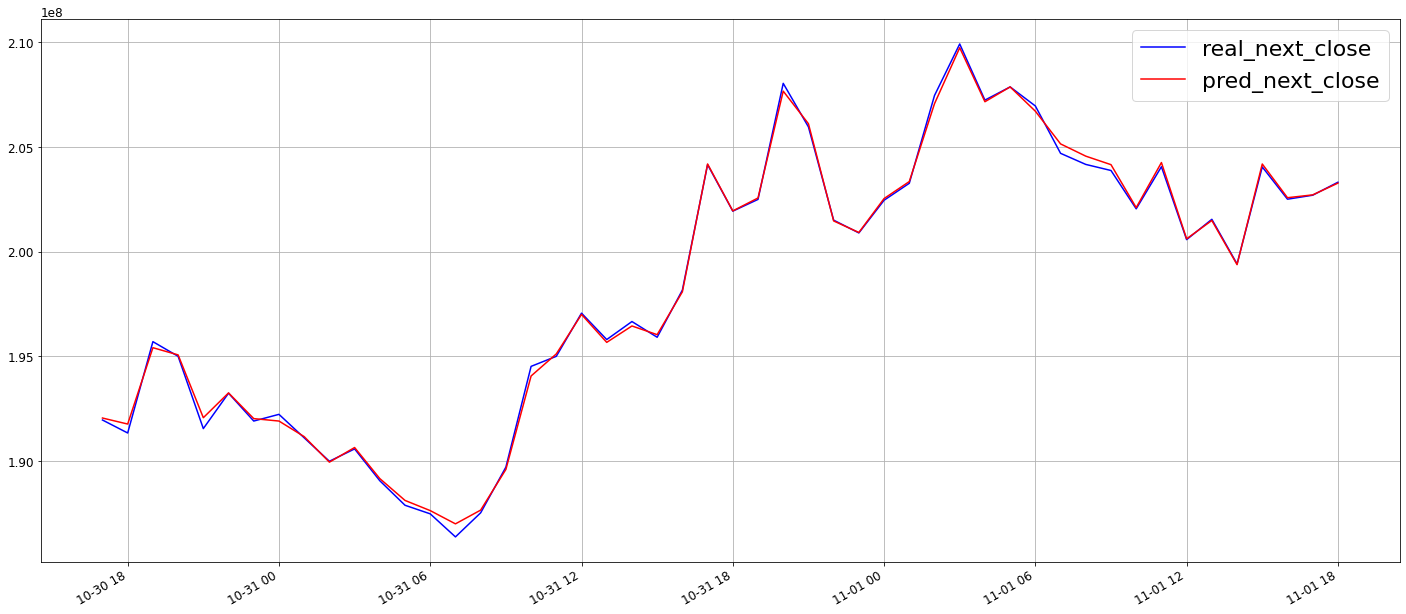

In [ ]:
fig, axe = plt.subplots(figsize=(20,9))

axe.plot(result_df.index, result_df['real_next_close'], color = 'blue', label = 'real_next_close')
axe.plot(result_df.index, result_df['pred_next_close'], color = 'red', label = 'pred_next_close')

plt.rcParams.update({'font.size': 22})

fig.autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.grid()

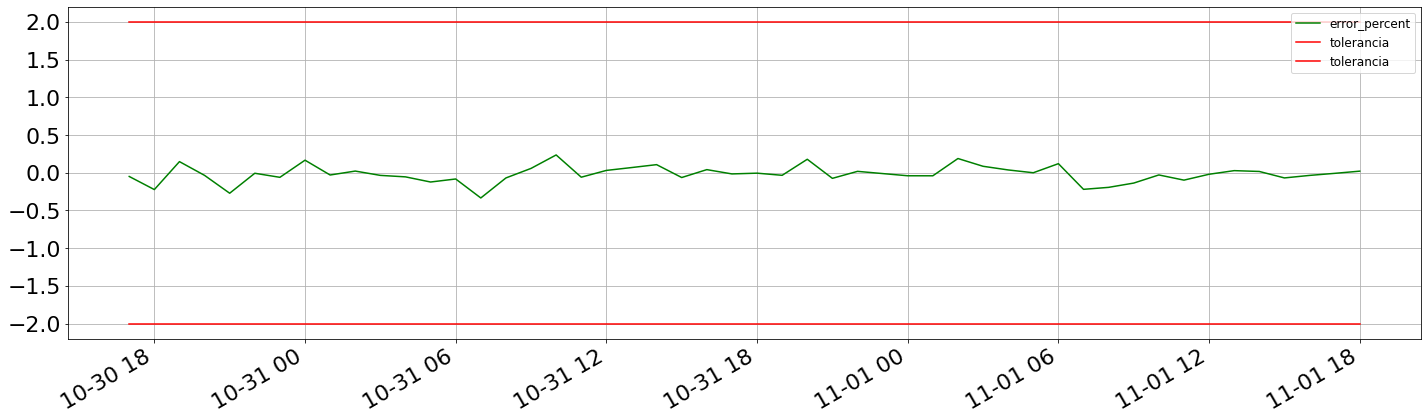

In [ ]:
fig, axe = plt.subplots(figsize=(20,6))

result_df['tolerancia+'] = 2
result_df['tolerancia-'] = -2

axe.plot(result_df.index, result_df['error_percent'], color = 'green', label = 'error_percent')

axe.plot(result_df.index[-prediction_candles:], result_df.iloc[-prediction_candles:]['tolerancia+'], color = 'red', label = 'tolerancia')
axe.plot(result_df.index[-prediction_candles:], result_df.iloc[-prediction_candles:]['tolerancia-'], color = 'red', label = 'tolerancia')

plt.rcParams.update({'font.size': 12})

fig.autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

In [ ]:
test_last_closed_line = test_last_closed_line.drop(['next_close'], axis=1)
pred_future = model.predict(test_last_closed_line)

In [ ]:

pred_future

array([2.039371e+08])

In [ ]:
'%f' % (pred_future/alt_adjust) # predicted price

'203.937100'

In [ ]:
time = test_last_closed_line.index[0]
delta = datetime.timedelta(hours=1) 
time+delta

Timestamp('2021-11-01 19:59:59.999000-0500', tz='America/Bogota')

In [ ]:

url_current_price = 'https://api.binance.com/api/v3/ticker/price?symbol=' + market
current_price = float(requests.get(url_current_price).json()['price'])

In [ ]:
current_price*alt_adjust, pred_future

(203000000.0, array([2.039371e+08]))

In [ ]:
current_price

203.0

In [ ]:
'%f' % (pred_future/alt_adjust)

'203.937100'